In [ ]:
import pathlib
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
import torch
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_neurips_2020_track1_small" / "DC"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_neurips_2020_track1_small.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

In [3]:
benchmark4 = PowerGridBenchmark(benchmark_name="Benchmark4",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )
LOADERS_PATH = DATA_PATH / benchmark4.benchmark_name / "loaders"

In [4]:
benchmark4.config.get_option("eval_dict")

{'ML': ['MSE_avg', 'MAE_avg', 'MAPE_avg', 'MAPE_90_avg', 'TIME_INF'],
 'Physics': ['LOSS_POS'],
 'IndRed': ['TIME_INF'],
 'OOD': ['MSE_avg', 'MAE_avg', 'MAPE_avg', 'MAPE_90_avg', 'TIME_INF']}

### Augmented Simulator (GNN)

In [9]:
from lips.augmented_simulators.torch_models.gnn import TorchGCN
from lips.augmented_simulators.torch_simulator import TorchSimulator
#from lips.dataset.scaler import StandardScaler

In [9]:
torch_sim = TorchSimulator(name="torch_gcn",
                           model=TorchGCN,
                           scaler=None,
                           log_path=LOG_PATH,
                           device="cuda:0", # use "cpu" if you don't have a GPU available on your machine
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark4",
                           sim_config_path=SIM_CONFIG_PATH / "torch_gnn.ini",
                           sim_config_name="GCN_CONFIG_RECOMMENDED_1" # use the default set of hyper parameters
                          )

In [ ]:
torch_sim.params

In [ ]:
torch_sim.train(benchmark4.train_dataset, benchmark4.val_dataset, save_path=None, epochs=1000, train_batch_size=128)

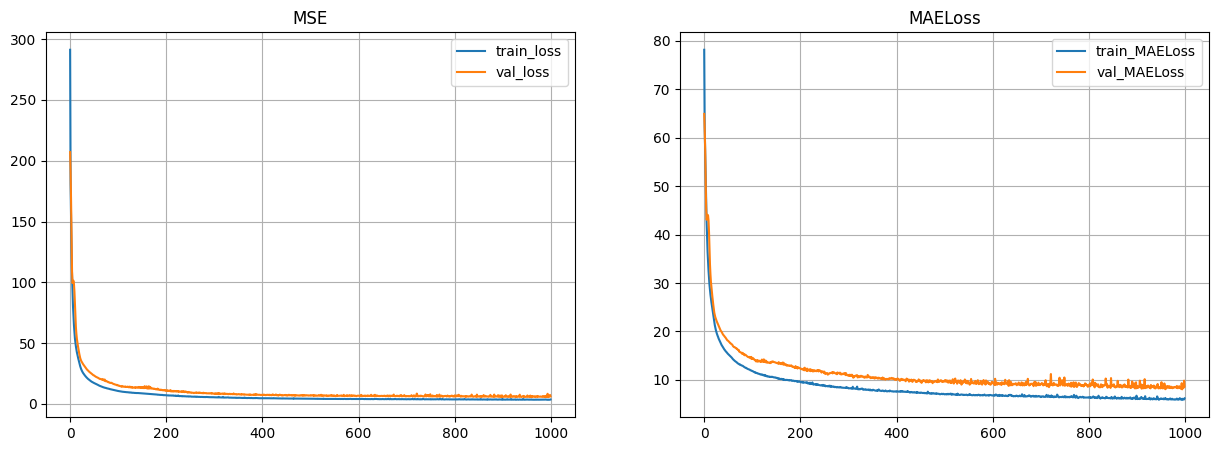

In [13]:
torch_sim.visualize_convergence()

### Save the model

In [14]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark4)
torch_sim.save(SAVE_PATH)

In [14]:
state_before_load = torch_sim._model.state_dict()

### Load the model

In [4]:
from lips.augmented_simulators.torch_models.gnn import TorchGCN
from lips.augmented_simulators.torch_simulator import TorchSimulator

torch_sim = TorchSimulator(name="torch_gcn",
                           model=TorchGCN,
                           scaler=None,
                           log_path=LOG_PATH,
                           device="cuda:0", # use "cpu" if you don't have a GPU available on your machine
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark4",
                           sim_config_path=SIM_CONFIG_PATH / "torch_gnn.ini",
                           sim_config_name="GCN_CONFIG_RECOMMENDED_1", # use the default set of hyper parameters
                           #attr_y=("theta_or", "theta_ex")
                          )

In [5]:
LOAD_PATH = get_path(TRAINED_MODEL_PATH, benchmark4)
torch_sim.restore(path=LOAD_PATH)

In [17]:
state_after_load = torch_sim._model.state_dict()

In [ ]:
for key in state_before_load.keys():
    print(key)
    assert torch.all(state_before_load.get(key) == state_after_load.get(key))

### Model Evaluation

In [6]:
metrics = benchmark4.evaluate_simulator(dataset="test", augmented_simulator=torch_sim, save_path=None, save_predictions=False, load_from_file=LOADERS_PATH)

/home/ubuntu/SYSTEMX/milad/venv/lips_irt/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")


processing the dataset:  test
processing the dataset:  test


In [7]:
metrics

{'test': {'ML': {'MSE_avg': {'theta_or': 0.16013146936893463,
    'theta_ex': 0.14176443219184875,
    'p_or': 31578944.0,
    'p_ex': 31578944.0},
   'MAE_avg': {'theta_or': 0.22603124380111694,
    'theta_ex': 0.2153654396533966,
    'p_or': 3423.616455078125,
    'p_ex': 3423.616455078125},
   'MAPE_avg': {'theta_or': 0.39813992381095886,
    'theta_ex': 5031621820416.0,
    'p_or': 3900009351217152.0,
    'p_ex': 3900009351217152.0},
   'MAPE_90_avg': {'theta_or': 0.04052439914669715,
    'theta_ex': nan,
    'p_or': 119.98328939839541,
    'p_ex': 119.98328939839541},
   'TIME_INF': 40.7051880559884},
  'Physics': {'LOSS_POS': {}},
  'IndRed': {'TIME_INF': 40.48066275706515}}}

In [16]:
metrics

{'test': {'ML': {'MSE_avg': {'theta_or': 0.0,
    'theta_ex': 0.0,
    'p_or': 31578944.0,
    'p_ex': 31578944.0},
   'MAE_avg': {'theta_or': 0.0,
    'theta_ex': 0.0,
    'p_or': 3423.6162109375,
    'p_ex': 3423.6162109375},
   'MAPE_avg': {'theta_or': 0.0,
    'theta_ex': 0.0,
    'p_or': 3900009351217152.0,
    'p_ex': 3900009351217152.0},
   'MAPE_90_avg': {'theta_or': 0.0,
    'theta_ex': nan,
    'p_or': 119.9832880351964,
    'p_ex': 119.9832880351964},
   'TIME_INF': 37.15022654598579},
  'Physics': {'LOSS_POS': {}},
  'IndRed': {'TIME_INF': 37.82175487000495}}}

<h1><span style="color:red">Draft</span></h1>

In [21]:
benchmark4.train_dataset.data["theta_or"].shape

(100000, 59)

In [23]:
predictions = torch_sim.predict(benchmark4._test_dataset, reconstruct_output=False)
theta_sub = predictions.reshape(-1, benchmark4.training_simulator._simulator.n_sub)

processing the dataset:  test


In [28]:
theta_sub.shape

(10000, 36)

In [49]:
obs = benchmark4.training_simulator._simulator.reset()
idx=0
obs.line_status = benchmark4._test_dataset.data["line_status"][idx]
obs.topo_vect = benchmark4._test_dataset.data["topo_vect"][idx]
lor_bus, lor_conn = obs._get_bus_id(obs.line_or_pos_topo_vect, obs.line_or_to_subid)
lex_bus, lex_conn = obs._get_bus_id(obs.line_ex_pos_topo_vect, obs.line_ex_to_subid)
index_array = np.vstack((np.arange(obs.n_line), lor_bus, lex_bus)).T
theta_pred_or = np.zeros((obs.n_line,1))
theta_pred_ex = np.zeros((obs.n_line,1))
for line in range(obs.n_line):
    if index_array[line, 1] == -1:
        theta_pred_or[line] = 0.
        theta_pred_ex[line] = 0.
    else:
        theta_pred_or[line] = theta_sub[idx][index_array[line, 1]]
        theta_pred_ex[line] = theta_sub[idx][index_array[line, 2]]  
    

In [ ]:
theta_pred_or